In [20]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tqdm import tqdm
from tensorflow.keras.applications import DenseNet121, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, callbacks, optimizers

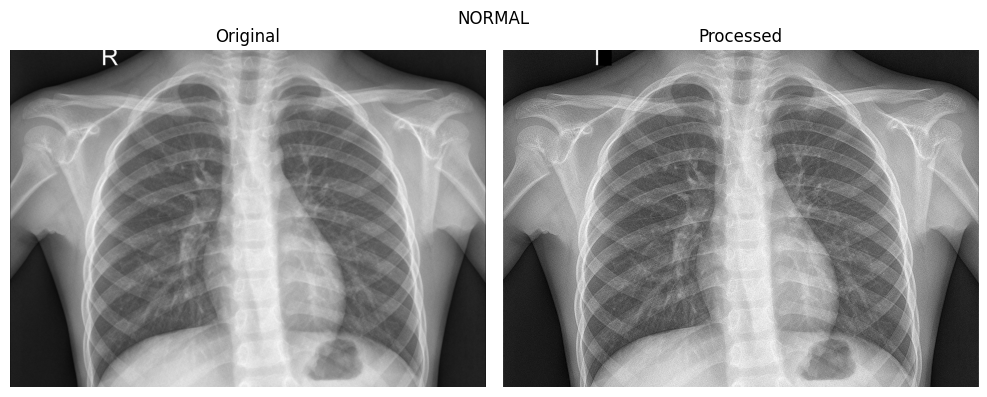

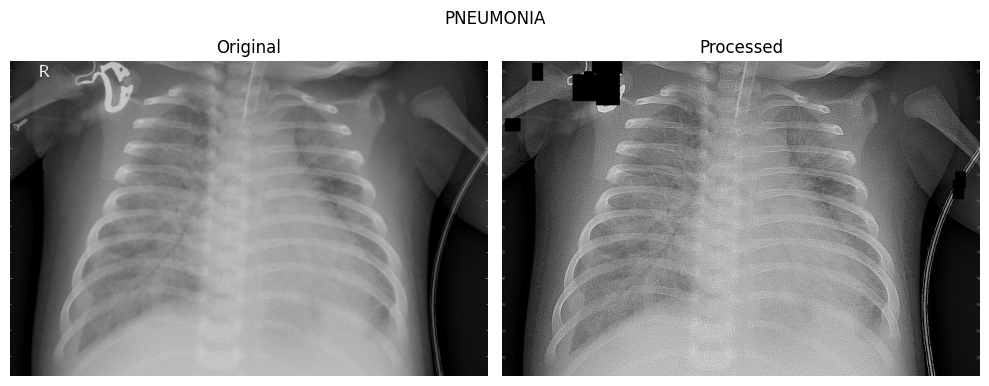


Semua hasil disimpan di folder: ./processed_output


In [ ]:
def preprocess_image(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    kernel_high_pass = np.array([[-1, -1, -1],
                                 [-1,  9, -1],
                                 [-1, -1, -1]])
    high_pass_img = cv2.filter2D(image, -1, kernel_high_pass)

    sobel_x = cv2.Sobel(high_pass_img, cv2.CV_64F, 1, 0, ksize=1)
    sobel_y = cv2.Sobel(high_pass_img, cv2.CV_64F, 0, 1, ksize=1)
    sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel = cv2.convertScaleAbs(sobel)

    _, thresholded = cv2.threshold(sobel, 150, 255, cv2.THRESH_BINARY)

    result = high_pass_img.copy()
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if 20 < w < 200 and 20 < h < 200:
            cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 0), -1)

    return result

def show_single_result(original_img, processed_img, title=""):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title("Processed")
    plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def process_and_save_images(input_folder, output_folder):
    for root, dirs, files in os.walk(input_folder):
        for subfolder in dirs:
            original_folder_path = os.path.join(root, subfolder)
            processed_folder_path = os.path.join(output_folder, subfolder + "_processed")

            os.makedirs(processed_folder_path, exist_ok=True)

            image_files = [f for f in os.listdir(original_folder_path)
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            if not image_files:
                continue

            # Tampilkan satu contoh
            example_image_path = os.path.join(original_folder_path, image_files[0])
            image = cv2.imread(example_image_path)
            if image is None:
                print(f"Gagal membaca gambar contoh: {example_image_path}")
                continue

            processed = preprocess_image(image)
            show_single_result(image, processed, title=subfolder)

            # Simpan semua hasil
            for file in image_files:
                img_path = os.path.join(original_folder_path, file)
                image = cv2.imread(img_path)
                if image is None:
                    print(f"Gagal membaca gambar: {img_path}")
                    continue
                processed = preprocess_image(image)
                save_path = os.path.join(processed_folder_path, file)
                cv2.imwrite(save_path, processed)

    print(f"\nSemua hasil disimpan di folder: {output_folder}")

zip_path = r"nexmediss\chest_xray.zip"
extract_dir = "./unzipped_data"
output_dir = "./processed_output"

if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

process_and_save_images(extract_dir, output_dir)


In [ ]:
input_folder = "nexmedis_cnn/processed_output/PNEUMONIA_processed"
output_bacteria = "nexmedis_cnn/processed_output/PNEUMONIA_bacteria"
output_virus = "nexmedis_cnn/processed_output/PNEUMONIA_virus"

os.makedirs(output_bacteria, exist_ok=True)
os.makedirs(output_virus, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith((".jpeg", ".jpg", ".png")):
        src_path = os.path.join(input_folder, filename)

        if 'bacteria' in filename.lower():
            dst_path = os.path.join(output_bacteria, filename)
        elif 'virus' in filename.lower():
            dst_path = os.path.join(output_virus, filename)
        else:
            print(f"[SKIP] Tidak terdeteksi bakteri/virus: {filename}")
            continue

        shutil.copy(src_path, dst_path)

print("Semua gambar pneumonia telah dipisahkan.")


Semua gambar pneumonia telah dipisahkan.


In [ ]:
base_dir = "nexmedis_cnn/processed_output/"  # ganti dengan path kamu
target_per_class = 2780  # jumlah target per kelas

# Data augmentasi
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_class_images(class_name):
    class_path = os.path.join(base_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    current_count = len(image_files)

    print(f" Augmenting '{class_name}': {current_count} ➡ {target_per_class}")

    i = 0
    while current_count < target_per_class:
        img_file = image_files[i % len(image_files)]
        img_path = os.path.join(class_path, img_file)

        img = load_img(img_path)
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        for batch in datagen.flow(x, batch_size=1, save_to_dir=class_path, save_prefix="aug", save_format="jpg"):
            current_count += 1
            if current_count >= target_per_class:
                break
        i += 1

# Lakukan augmentasi hanya pada kelas yang kurang dari target
for class_name in ["NORMAL_processed", "PNEUMONIA_virus"]:
    augment_class_images(class_name)

print("\n Dataset balancing selesai")


 Augmenting 'NORMAL_processed': 1583 ➡ 2780
 Augmenting 'PNEUMONIA_virus': 1493 ➡ 2780

 Dataset balancing selesai


In [18]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import os

dataset_dir = "nexmedis_cnn/processed_output"
all_images, all_labels = [], []
class_names = sorted(os.listdir(dataset_dir))  # pastikan urut
print("Classes:", class_names)

for label in class_names:
    for fname in os.listdir(os.path.join(dataset_dir, label)):
        all_images.append(os.path.join(dataset_dir, label, fname))
        all_labels.append(label)

label_to_index = {name: i for i, name in enumerate(class_names)}
y_int = np.array([label_to_index[label] for label in all_labels])
y_cat = tf.keras.utils.to_categorical(y_int, num_classes=len(class_names))

X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, y_cat, test_size=0.3, stratify=y_int, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=np.argmax(y_temp, axis=1), random_state=42)

IMG_SIZE = 224

def preprocess(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def prepare_dataset(paths, labels, batch_size=32, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(len(paths))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds_64 = prepare_dataset(X_train, y_train, batch_size=64)
val_ds_64 = prepare_dataset(X_val, y_val, batch_size=64, shuffle=False)
test_ds_64 = prepare_dataset(X_test, y_test, batch_size=64, shuffle=False)


Classes: ['NORMAL_processed', 'PNEUMONIA_bacteria', 'PNEUMONIA_virus']


DenseNet121, lr 0.001, batchsize 64, epoch 5, Adam optimizers

In [21]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

model_densenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model_densenet.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Training
history_densenet = model_densenet.fit(
    train_ds_64,
    validation_data=val_ds_64,
    epochs=5,
    callbacks=[earlystop_cb]
)

# Evaluate
test_loss, test_acc = model_densenet.evaluate(test_ds_64)
print(f"DenseNet121 Test Accuracy: {test_acc:.4f}")

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.6828 - loss: 0.8010 - val_accuracy: 0.8282 - val_loss: 0.3972
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.8430 - loss: 0.4075 - val_accuracy: 0.8363 - val_loss: 0.3786
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.8505 - loss: 0.3728 - val_accuracy: 0.8445 - val_loss: 0.3687
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8631 - loss: 0.3397 - val_accuracy: 0.8477 - val_loss: 0.3542
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8716 - loss: 0.3385 - val_accuracy: 0.8518 - val_loss: 0.3489
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.8501 - loss: 0.3652
DenseNet121 Test Accuracy: 0.8583


DenseNet121, lr 0.01, batchsize 64, epoch 5, Adam optimizers

In [22]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

model_densenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model_densenet.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Training
history_densenet = model_densenet.fit(
    train_ds_64,
    validation_data=val_ds_64,
    epochs=5,
    callbacks=[earlystop_cb]
)

# Evaluate
test_loss, test_acc = model_densenet.evaluate(test_ds_64)
print(f"DenseNet121 Test Accuracy: {test_acc:.4f}")

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.6656 - loss: 1.5138 - val_accuracy: 0.8322 - val_loss: 0.4067
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.8278 - loss: 0.4277 - val_accuracy: 0.8396 - val_loss: 0.3870
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.8418 - loss: 0.3925 - val_accuracy: 0.8306 - val_loss: 0.3902
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.8474 - loss: 0.3971 - val_accuracy: 0.8428 - val_loss: 0.3689
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.8489 - loss: 0.3675 - val_accuracy: 0.8502 - val_loss: 0.3741
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8462 - loss: 0.3702
DenseNet121 Test Accuracy: 0.8493


ResNet50V2, lr 0.001, Batchsize 64, epoch 5, adam optimizers

In [23]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Build full model
model_resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile
model_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Training
history_resnet = model_resnet.fit(
    train_ds_64,
    validation_data=val_ds_64,
    epochs=5,
    callbacks=[earlystop_cb]
)

# Evaluate
test_loss, test_acc = model_resnet.evaluate(test_ds_64)
print(f"ResNet50V2 Test Accuracy: {test_acc:.4f}")

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.6981 - loss: 2.1037 - val_accuracy: 0.8363 - val_loss: 0.4166
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.8413 - loss: 0.3975 - val_accuracy: 0.8510 - val_loss: 0.3725
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.8507 - loss: 0.3648 - val_accuracy: 0.8379 - val_loss: 0.3779
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.8535 - loss: 0.3615 - val_accuracy: 0.8453 - val_loss: 0.3811
20/20 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.8441 - loss: 0.3888
ResNet50V2 Test Accuracy: 0.8461


ResNet50V2, lr 0.01, Batchsize 64, epoch 5, adam optimizers

In [24]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Build full model
model_resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile
model_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Training
history_resnet = model_resnet.fit(
    train_ds_64,
    validation_data=val_ds_64,
    epochs=5,
    callbacks=[earlystop_cb]
)

# Evaluate
test_loss, test_acc = model_resnet.evaluate(test_ds_64)
print(f"ResNet50V2 Test Accuracy: {test_acc:.4f}")

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.7229 - loss: 0.7307 - val_accuracy: 0.8339 - val_loss: 0.3967
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8452 - loss: 0.3823 - val_accuracy: 0.8445 - val_loss: 0.3653
Epoch 3/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8704 - loss: 0.3284 - val_accuracy: 0.8371 - val_loss: 0.3715
Epoch 4/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.8744 - loss: 0.2990 - val_accuracy: 0.8428 - val_loss: 0.3639
Epoch 5/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8788 - loss: 0.3016 - val_accuracy: 0.8404 - val_loss: 0.3570
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 972ms/step - accuracy: 0.8468 - loss: 0.3490
ResNet50V2 Test Accuracy: 0.8567


In [25]:
train_ds_128 = prepare_dataset(X_train, y_train, batch_size=128)
val_ds_128 = prepare_dataset(X_val, y_val, batch_size=128, shuffle=False)
test_ds_128 = prepare_dataset(X_test, y_test, batch_size=128, shuffle=False)

DenseNet121, lr 0.001, batchsize 128, epoch 5, Adam optimizers

In [26]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

model_densenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model_densenet.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Training
history_densenet = model_densenet.fit(
    train_ds_128,
    validation_data=val_ds_128,
    epochs=5,
    callbacks=[earlystop_cb]
)

# Evaluate
test_loss, test_acc = model_densenet.evaluate(test_ds_128)
print(f"DenseNet121 Test Accuracy: {test_acc:.4f}")

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.6508 - loss: 0.8336 - val_accuracy: 0.8184 - val_loss: 0.4432
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.8196 - loss: 0.4421 - val_accuracy: 0.8379 - val_loss: 0.3872
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 180s 4s/step - accuracy: 0.8506 - loss: 0.3755 - val_accuracy: 0.8371 - val_loss: 0.3824
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.8482 - loss: 0.3732 - val_accuracy: 0.8388 - val_loss: 0.3697
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.8561 - loss: 0.3577 - val_accuracy: 0.8502 - val_loss: 0.3618
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.8494 - loss: 0.3846
DenseNet121 Test Accuracy: 0.8542


DenseNet121, lr 0.01, batchsize 128, epoch 5, Adam optimizers

In [27]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

model_densenet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model_densenet.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Training
history_densenet = model_densenet.fit(
    train_ds_128,
    validation_data=val_ds_128,
    epochs=5,
    callbacks=[earlystop_cb]
)

# Evaluate
test_loss, test_acc = model_densenet.evaluate(test_ds_128)
print(f"DenseNet121 Test Accuracy: {test_acc:.4f}")

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 183s 4s/step - accuracy: 0.5945 - loss: 2.2075 - val_accuracy: 0.8306 - val_loss: 0.4134
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 181s 4s/step - accuracy: 0.8404 - loss: 0.4065 - val_accuracy: 0.8347 - val_loss: 0.3907
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.8445 - loss: 0.3907 - val_accuracy: 0.8355 - val_loss: 0.3713
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.8505 - loss: 0.3715 - val_accuracy: 0.8396 - val_loss: 0.3715
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.8450 - loss: 0.3755 - val_accuracy: 0.8428 - val_loss: 0.3636
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.8463 - loss: 0.3732
DenseNet121 Test Accuracy: 0.8502


ResNet50V2, lr 0.01, batchsize 128, epoch 5, Adam optimizers

In [28]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Build full model
model_resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile
model_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Training
history_resnet = model_resnet.fit(
    train_ds_128,
    validation_data=val_ds_128,
    epochs=5,
    callbacks=[earlystop_cb]
)

# Evaluate
test_loss, test_acc = model_resnet.evaluate(test_ds_128)
print(f"ResNet50V2 Test Accuracy: {test_acc:.4f}")

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 134s 3s/step - accuracy: 0.6759 - loss: 1.5161 - val_accuracy: 0.8233 - val_loss: 0.4084
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.8425 - loss: 0.3915 - val_accuracy: 0.8420 - val_loss: 0.3664
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.8587 - loss: 0.3562 - val_accuracy: 0.8477 - val_loss: 0.3582
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8663 - loss: 0.3288 - val_accuracy: 0.8355 - val_loss: 0.3862
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8611 - loss: 0.3336 - val_accuracy: 0.8477 - val_loss: 0.3532
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8540 - loss: 0.3598
ResNet50V2 Test Accuracy: 0.8591


ResNet50V2, lr 0.001, batchsize 128, epoch 5, Adam optimizers

In [29]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

# Build full model
model_resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile
model_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping
earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Training
history_resnet = model_resnet.fit(
    train_ds_128,
    validation_data=val_ds_128,
    epochs=5,
    callbacks=[earlystop_cb]
)

# Evaluate
test_loss, test_acc = model_resnet.evaluate(test_ds_128)
print(f"ResNet50V2 Test Accuracy: {test_acc:.4f}")

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.7141 - loss: 0.7116 - val_accuracy: 0.8363 - val_loss: 0.3987
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.8603 - loss: 0.3619 - val_accuracy: 0.8396 - val_loss: 0.3812
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.8713 - loss: 0.3237 - val_accuracy: 0.8436 - val_loss: 0.3810
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.8738 - loss: 0.3181 - val_accuracy: 0.8453 - val_loss: 0.3599
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.8896 - loss: 0.2812 - val_accuracy: 0.8526 - val_loss: 0.3629
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.8505 - loss: 0.3642
ResNet50V2 Test Accuracy: 0.8550
